# Thermal Scattering

For this notebook, we will take a look at how thermal multiple scattering affects the secondary eclipse emission spectrum of a hot Jupiter. 

## An Introduction to Thermal Scattering

In observing geometries where we are measuring light from a substellar object directly (e.g. secondary eclipse or via direct imaging), it is important to consider absorption, emission, and (often) directional scattering. This is different than for transmission spectra geometry, where any absorption or scattering process is often assumed to simply combine to form total extinction experienced by a beam of photons.

The observable thermal emission from the top of the atmosphere originates from deep, hotter atmospheric pressures. As this thermal emission propagates from the deep atmosphere, a beam interact with gas-phase molecular species by either losing photons through absorption or via the gas emitting new photons into the beam. 

Absorption features form when the pressure-temperature profile decreases with decreasing pressure/increasing altitude. Gas-phase species then impart absorption features into the observed spectrum, since at the wavelength where they absorb starlight we can only see down to the cooler upper regions of the atmosphere, where there is less emitted flux.

Conversely, emission features can form if the pressure-temperature profile is hotter in the upper atmosphere (a thermal inversion).

### The Role of Scattering

Several scattering processes can alter the direction of a beam of thermal photons propagating through an atmosphere.

*Rayleigh scattering* from molecules in the atmosphere (usually $\rm{H_2}$) is a symmetric process that equally scatters light in the forward and backwards direction. As thermal emission propagates up to escape a substellar object, Rayleigh scattering will scatter 50% of the light in the forward direction and 50% of it in the backward direction (you can think of forward scattering as a process that 'helps' thermal emission escape the object).

*Mie scattering* from aerosols interact with thermal photons differently. Aerosols can absorb or scattering incoming light in a complex wavelength-dependent manner. When light is absorbed, it is lost to the upwards propagating beam. When light is scattered, aerosols can back-scatter and forward-scatter light very asymmetrically. The larger a Mie scattering aerosol particle, the more likely it is to forward scatter radiation (more likely to 'help' photons escape by throwing photons in the forward direction). The probability of an aerosol absorbing or scattering, and the probability of an aerosol forward or back scattering a photon, are dictated by the single scattering albedo (ω) and asymmetry parameter (g), as we will see below. Also as we will see below, the scattering properties of aerosols can introduce 'scattering' features into an emission spectrum, even if the temperature-pressure profile is isothermal.

Given that both aerosols and gas-phase molecules have a probability to forward scatter and back scatter, you can imagine that backscattered photons might be backscattered again and therefore put them back in the upwards propagating beam. This is called multiple scattering.

Reflection (covered in a later tutorial) is a form of multiple scattering where light from the star is back-scattered by Rayleigh and Mie scattering in a substellar object's atmosphere. We will explore this form of multiple scattering more in the [\"Reflection in Hot Jupiters\"](reflection.html) tutorial.

<img src="../../_static/notebook_images/Emission-cloud-effect.png" />

## Thermal Scattering in POSEIDON

POSEIDON v1.2 includes thermal multiple scattering modelling capabilities adapted from the [PICASO](https://natashabatalha.github.io/picaso/) package developed by Natasha Batalha. If you use POSEIDON for thermal emission with scattering enabled, please cite [Batalha et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...878...70B/abstract) and [Mukherjee et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023ApJ...942...71M/abstract) to recognise the significant work of the PICASO team in developing this capability.

Note that the PICASO is *not* a modular dependency of POSEIDON, rather several radiative transfer functions from PICASO have been adapted to work within the internal structure of POSEIDON.


## Hot Jupiter Scattering

During secondary eclipse, aerosols can impart scattering features even if the atmosphere is isothermal. 

We will use the hot Jupiter HD 189733b as an example to illustrate thermal scattering..

In [1]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, define_model, \
                          wl_grid_constant_R, read_opacities

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

#***** Model wavelength grid *****#

wl_min = 0.5      # Minimum wavelength (um)
wl_max = 20       # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
a_p = 0.03142*au

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)

In [2]:
#***** Define stellar properties *****#

R_s = 0.78*R_Sun   # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13       # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58     # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

Let's create two models, one with thermal scattering turned on and one with thermal scattering turned off. 

In order to turn in scattering, we just set `scattering = True` in our `define_model` function.

We will also include enstatite ($\rm{MgSiO_3}$) Mie clouds from the precomputed aerosol database. The aerosol database includes the asymmetry parameter and single scattering albedo, which are utilized to determine the scattering/absorbing properties of Mie scattering aerosols. 

We will explore what the asymmetry parameter and single scattering albedo are later in this notebook.

In [3]:
#***** Define model *****#

model_name_scattering = 'Thermal Multiple Scattering'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['MgSiO3'] # <---- Lets include enstatite (MgSiO3) aerosols 

# Create the model object
model_scattering = define_model(model_name_scattering, bulk_species, param_species, 
                     PT_profile = 'isotherm',
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with directional scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering

Reading in database for aerosol cross sections...


In [4]:
#***** Define model *****#

model_name_no_scattering = 'No Thermal Multiple Scattering'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['MgSiO3'] # <---- Lets include enstatite (MgSiO3) aerosols 

model_no_scattering = define_model(model_name_no_scattering, bulk_species, param_species, 
                                   PT_profile = 'isotherm',
                                   cloud_model = 'Mie',cloud_type = 'slab',
                                   aerosol_species = aerosol_species,
                                   scattering = False)   # <---- Set scattering = False for scattering processes to be considered 100% extinctive 

Reading in database for aerosol cross sections...


Lets take a quick preview of the optical proeprties of MgSiO3 with this helper function

MgSiO3
Reading in database for aerosol cross sections...
Loading in :  ../../../POSEIDON/reference_data/refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/MgSiO3.txt
Loading in :  ../../../POSEIDON/reference_data/refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/MgSiO3.txt


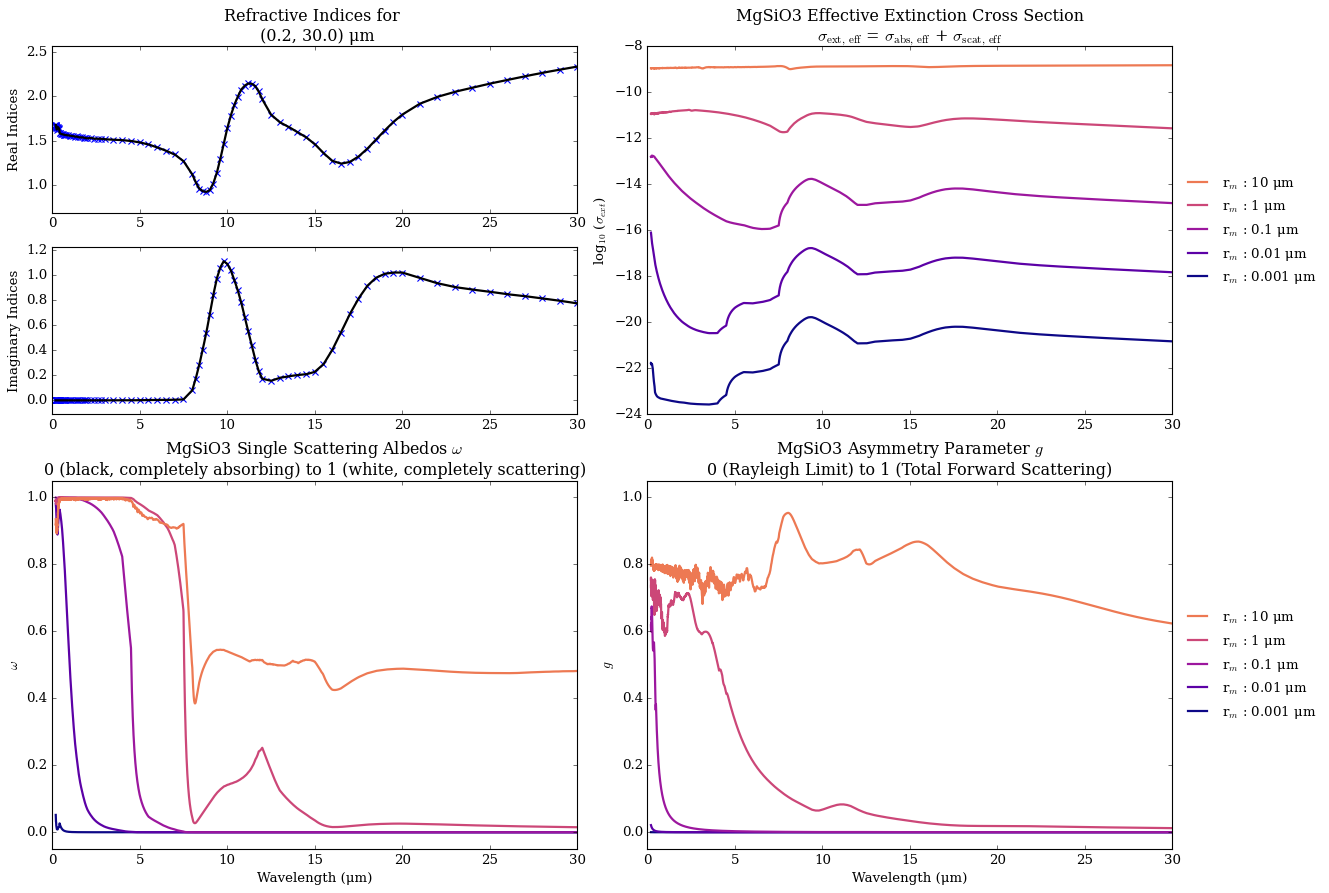

In [5]:
from POSEIDON.clouds import database_properties_plot

# All the refractive index txt files with names corresponding to their name in supported_species.py are
# found in /refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/

refractive_index_path = '../../../POSEIDON/reference_data/refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/'
file_name = refractive_index_path + 'MgSiO3.txt'

database_properties_plot(file_name)

In [6]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100    # Same as prior range for T
T_fine_max = 3100   # Same as prior range for T
T_fine_step = 20    # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 1 bar

#***** Run atmospheric retrieval *****#
opac = read_opacities(model_scattering, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
Opacity pre-interpolation complete.


Let's make an isothermal atmosphere at the equilibrium temperature of HD 189733 b (1200 K) with an enstatite slab that ranges from 100 to 0.1 bars. 

We will pick large particles (1 um sized), since larger aerosols have stronger scattering properties.

In [7]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

T                     =   1200 # <---- Equilibrium temperature of HD 1897333 b 

log_CO                =   -5.30 # <---- Some proxy gas-phase mixing ratios
log_CO2               =   -3.07 # <---- Note that gas-phase species have no features in isothermal atmospheres in emission
log_H2O               =   -5.33  

log_P_top_slab_MgSiO3 =   -1    # <---- Top of the slab is at 0.1 bars
Delta_log_P_MgSiO3    =   3     # <---- Slab extends down to 100 bars
log_r_m_MgSiO3        =   0     # <---- Large particles (1 um) have stronger scattering properties 
log_X_MgSiO3          =   -10   # <---- Modest mixing ratio of enstatite in the slab

PT_params = np.array([T])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere= make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                            PT_params, log_X_params, cloud_params) # <---- We can use the same atmosphere object for both models

Let's also make an atmosphere with no gas-phase species in it.

In [8]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

T                     =   1200 # <---- Equilibrium temperature of HD 1897333 b 

log_CO                =   -100 # <---- -100 is a proxy for no gas-phase species
log_CO2               =   -100 
log_H2O               =   -100  

log_P_top_slab_MgSiO3 =   -1    # <---- Top of the slab is at 0.1 bars
Delta_log_P_MgSiO3    =   3     # <---- Slab extends down to 100 bars
log_r_m_MgSiO3        =   0     # <---- Large particles (1 um) have stronger scattering properties 
log_X_MgSiO3          =   -10   # <---- Modest mixing ratio of enstatite in the slab

PT_params = np.array([T])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere_no_gas_phase = make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                                          PT_params, log_X_params, cloud_params) # <---- We can use the same atmosphere object for both models

Let's take a look at the P-T, chemical, and cloud profiles for our model atmosphere.

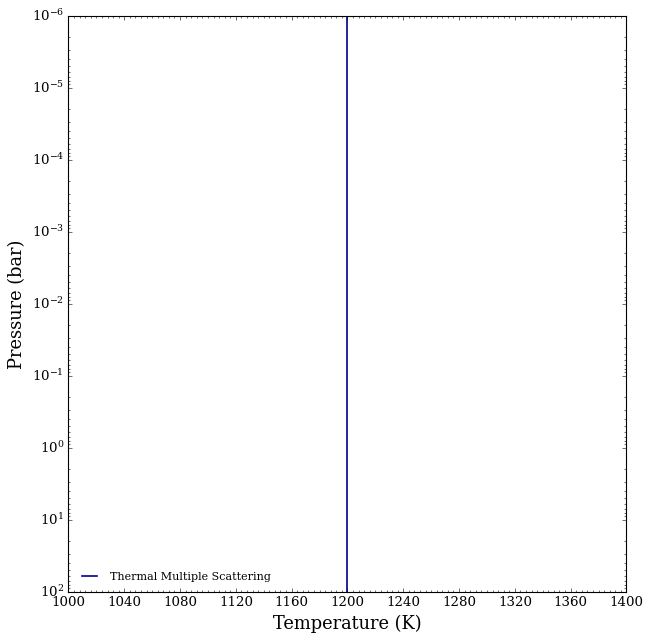

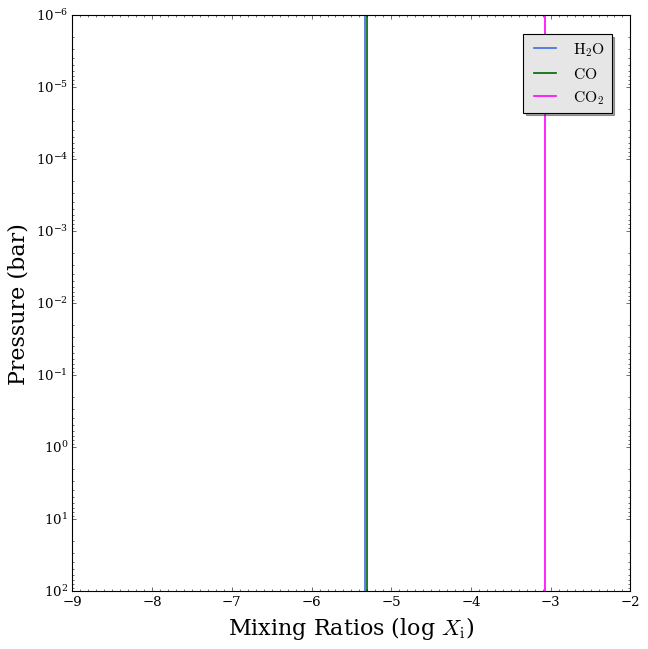

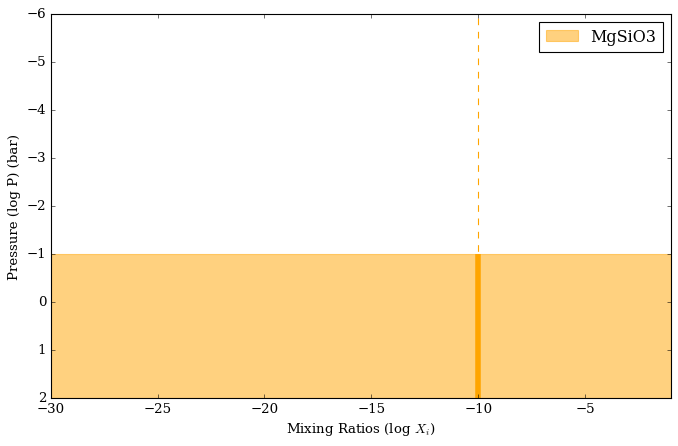

In [9]:
from POSEIDON.visuals import plot_PT, plot_chem
from POSEIDON.clouds import plot_clouds

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_scattering, atmosphere)


fig_chem = plot_chem(planet, model_scattering, atmosphere, 
                     plot_species = ['H2O', 'CO', 'CO2'],
                     log_X_min = -9, log_P_max = 2.0)

plot_clouds(planet,model_scattering,atmosphere)

Let's generate the secondary-eclipse spectra and plot it up!

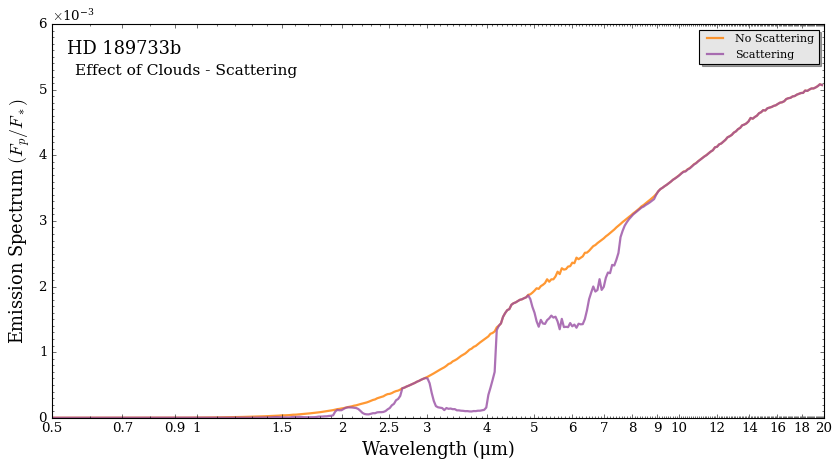

In [10]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere, opac, wl, 
                                 spectrum_type = 'emission', save_spectrum = True) # <---- Remember to set spectrum_type = 'emission'!

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere, opac, wl, 
                              spectrum_type = 'emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth',                         # <---- Remember to set y_unit!
                        spectra_labels = ['No Scattering', 'Scattering'], 
                        legend_location = 'upper right', wl_axis = 'log', 
                        colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title, figure_shape = 'wide')

As we can see, even in isothermal environments, aerosols can impart scattering features that will cause the spectrum to deviate from a blackbody.

Now let's see how it looks like with no gas-phase species.

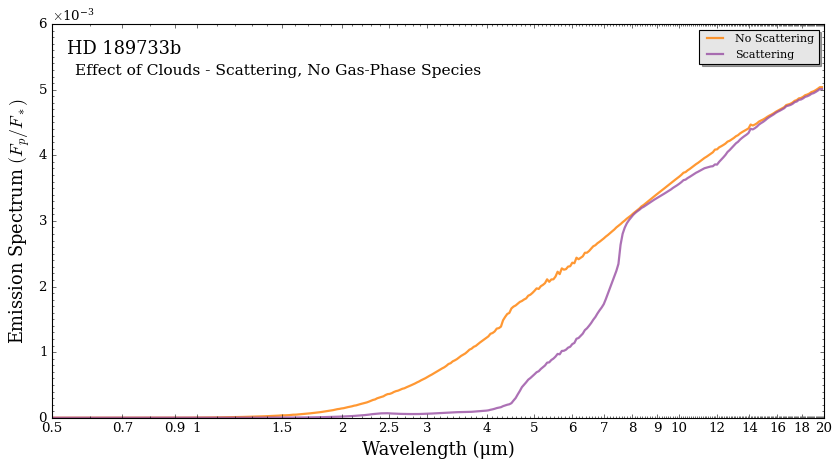

In [11]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere_no_gas_phase, # <---- New atmosphere object
                                 opac, wl, spectrum_type = 'emission')  # <---- Remember to set spectrum_type = 'emission'!

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere_no_gas_phase,
                              opac, wl, spectrum_type = 'emission')

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering, No Gas-Phase Species'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth',                          # <---- Remember to set y_unit!
                        spectra_labels = ['No Scattering', 'Scattering'], 
                        legend_location = 'upper right', wl_axis = 'log', 
                        colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title, figure_shape = 'wide')

Without gas-phase species, the enstatite slab is causing a general decrease in flux across the spectrum. 

An eagle-eyed user would notice that the spectrum with gas-phase species included has 'emission features' in the scattering model where the gas-phase absorption features are (4-5 microns is the CO2 and CO combined feature). In an isothermal atmosphere, these gas species are acting as scatterers and putting photons back into the beam via multiple scattering.

Lets explore what is causing the decrease in flux due to scattering by looking at enstatite's (1 um sized) effective extinction coefficient, single scattering albedo, and asymmetry parameter.

We will pull these properties directly from the precomputed aerosol database.

In [12]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

species = 'MgSiO3'

# Load in the grid 
aerosol_grid = load_aerosol_grid([species])

# Set the particle size to 1 um 
r_m = 1

# This function loads in the grid 
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Lets load in the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

Reading in database for aerosol cross sections...


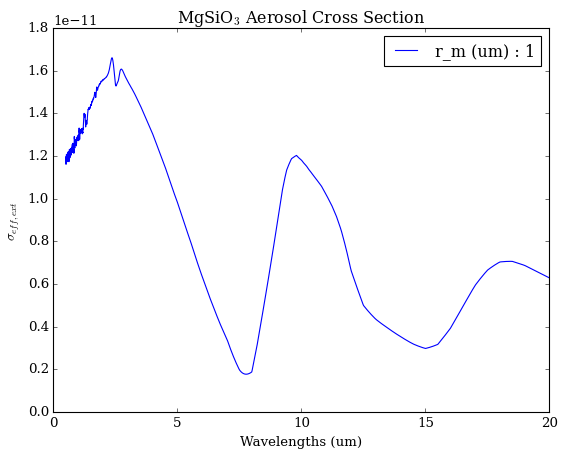

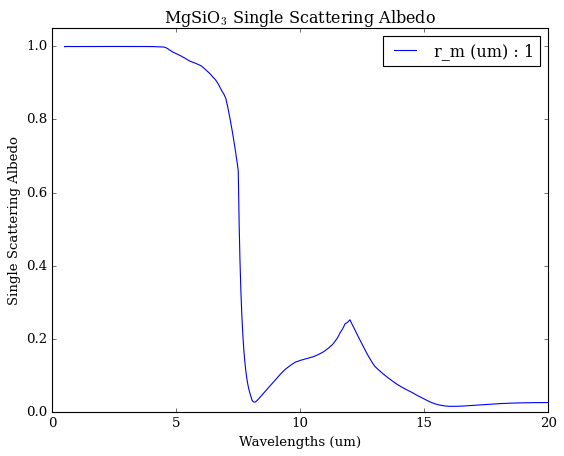

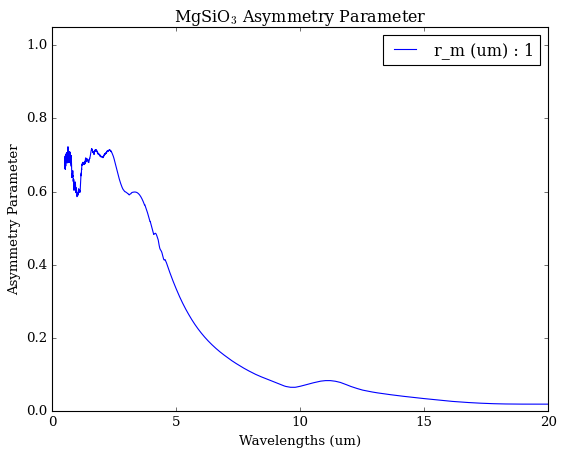

In [13]:
# Plotting

label = 'r_m (um) : ' + str(r_m)
title = 'MgSiO$_3$ Aerosol Cross Section'

plt.plot(wl,eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('$\sigma_{eff,ext}$')
plt.show()

title = 'MgSiO$_3$ Single Scattering Albedo'

plt.plot(wl,eff_w, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Single Scattering Albedo')
plt.ylim((0,1.05))
plt.show()

title = 'MgSiO$_3$ Asymmetry Parameter'

plt.plot(wl,eff_g, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Asymmetry Parameter')
plt.ylim((0,1.05))
plt.show()

The effective extinction cross section is the combined scattering and absorption cross section. The scattering function disentangles the scattering and absorption properties by using the single scattering albedo and asymmetry parameter. 

The single scattering albedo defines the probability of a particle absorbing or scattering a photon. A single scattering albedo of 0 means that 100% of photons will be absorbed whereas a single scattering albedo of 1 means that 100% of photons will be scattered. 

The asymmetry parameter defines the probability of a particle forward scattering or back scattering a photon. An asymmetry parameter of 0 means that 50% of particles will be forward scattered (the Rayleigh limit), and an asymmetry parameter of 1 means that 100% of particles will be forward scattered. 

The decrease in flux in the spectrum due to scattering is a complex interplay between gas-phase and aerosol scattering and multiple scattering that is determined by these parameters. To see an example of a strong forward scattering atmosphere that increases flux, see the 'Y-Dwarf with Scattering Clouds' in the brown dwarf tutorial.

### Sub-Micron Aerosols in a Non-isothermal Atmosphere Without Thermal Inversions

Let's look at sub-micron aerosol absorption in a atmosphere with a non-isothermal pressure-temperature profile without thermal inversions. 

Sub-micron aerosols are less prone to imparting 'scattering' features, and will instead impart absorption and emission features much like the gas-phase (this is because Mie-scattering occurs when the wavelength of light is on par with the particle size. In the previous case we use 1 um sized particles and looked at scattering features in the 1-10 micron range. In this case, we are looking at sub-micron sized particles which means that the absorptions feature will dominate over the Mie scattering ones).

We will use a new aerosol species, Mg2SiO4_crystalline, which has sharp features and the new Guillot dayside profile.

Since the temperature decreases with height, we expect both the gas and aerosol species to impart absorption features in the atmosphere. 

In [14]:
#***** Define model *****#

model_name_scattering = 'Thermal Multiple Scattering - Non Isothermal'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['Mg2SiO4_crystalline'] # <---- Lets include crystalline forsterite (Mg2SiO4) crystals, which have sharp features at 10 um

# Create the model object
model_scattering = define_model(model_name_scattering, bulk_species, param_species, 
                     PT_profile = 'Guillot_dayside',          # <---- Lets use the new Guillot_dayside PT profile
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with directional scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering

model_name_no_scattering = 'No Thermal Multiple Scattering - Non Isothermal'

model_no_scattering = define_model(model_name_no_scattering, bulk_species, param_species, 
                     PT_profile = 'Guillot_dayside',          # <---- Lets use the new Guillot_dayside PT profile
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with directional scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering


Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


Let's preview the optical properties of crystalline Mg2SiO4. From below, it looks like sub-micron sized particles have three sharp features from 10-13 um. 

Mg2SiO4_crystalline
Reading in database for aerosol cross sections...
Loading in :  ../../../POSEIDON/reference_data/refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/Mg2SiO4_crystalline.txt
Loading in :  ../../../POSEIDON/reference_data/refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/Mg2SiO4_crystalline.txt


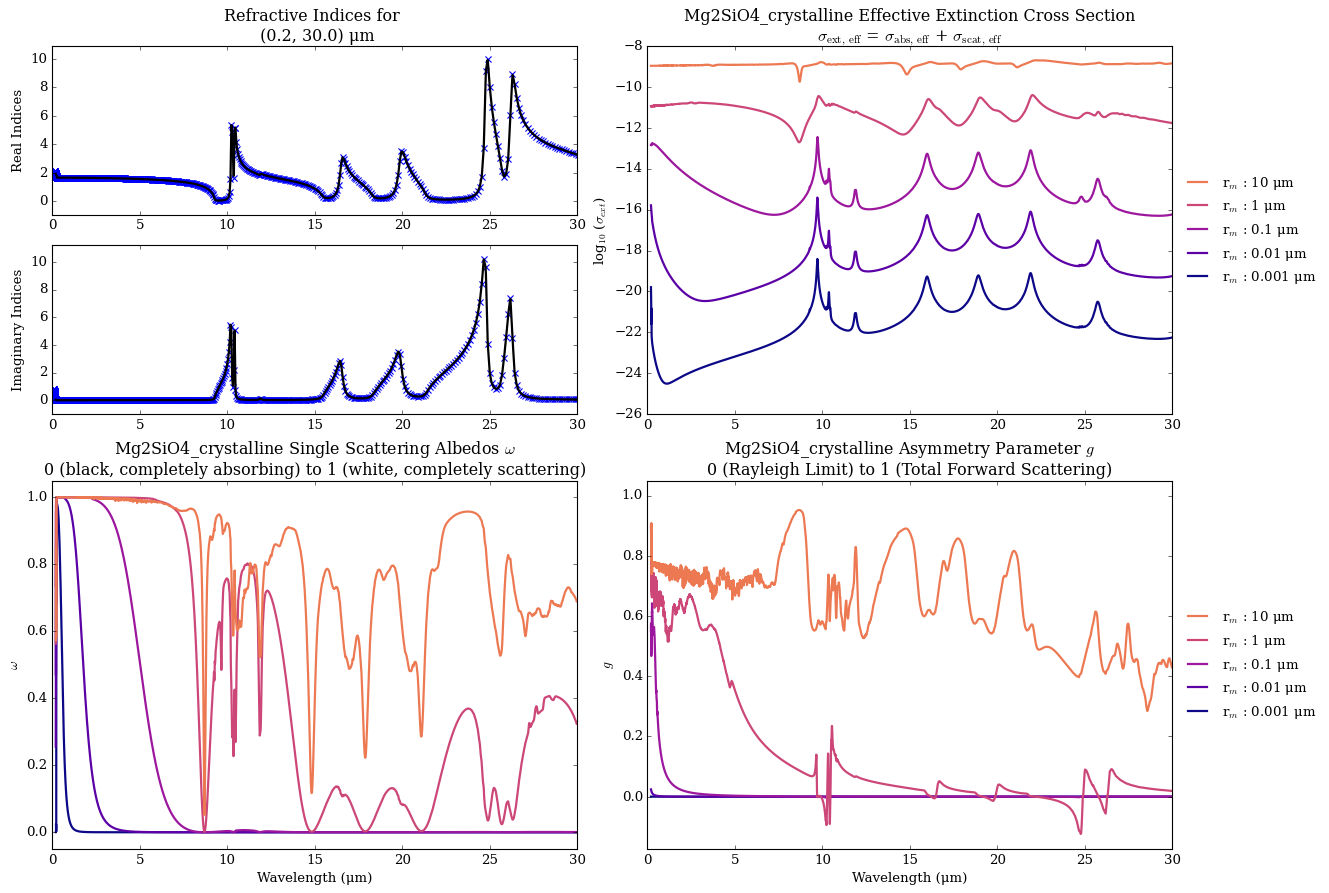

In [15]:
from POSEIDON.clouds import database_properties_plot

# All the refractive index txt files with names corresponding to their name in supported_species.py are
# found in /refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/

refractive_index_path = '../../../POSEIDON/reference_data/refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/'
file_name = refractive_index_path + 'Mg2SiO4_crystalline.txt'

database_properties_plot(file_name)

In [16]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

log_kappa_IR          =   -4   # <---- IR opacity 
log_gamma             =   -0.4 # <---- Ratio between IR and optical opacity 
T_int                 =   600  # <---- Internal temperature 
T_equ                 =   1200 # <---- Equilibrium temperature 

log_CO                =   -5 # <---- Some proxy gas-phase mixing ratios
log_CO2               =   -5  
log_H2O               =   -5 # <---- Water gas has a strong cross section in the mid-infrared that will 'cover' aerosol features, so we set it low

log_P_top_slab_MgSiO3 =   -6    # We will make the aerosols span the entire atmosphere
Delta_log_P_MgSiO3    =   8     
log_r_m_MgSiO3        =   -2    # <---- Sub-Micron sized particles have less scattering features
log_X_MgSiO3          =   -13   # <---- Modest uniform mixing ratio

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, cloud_params) 

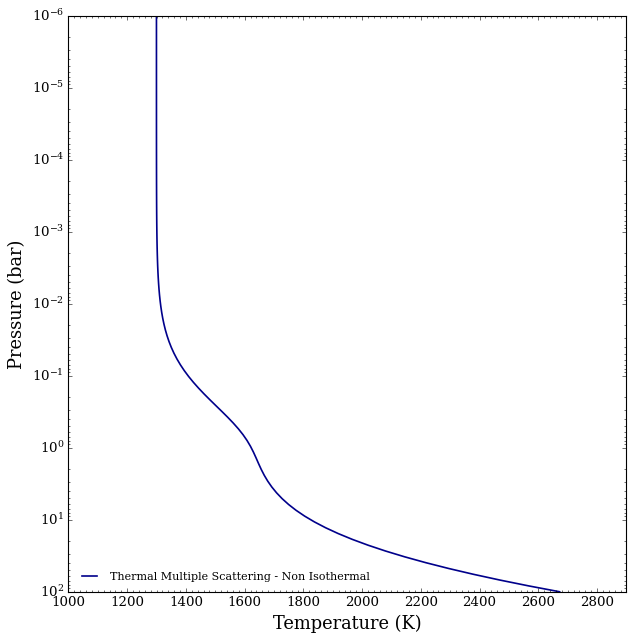

In [17]:
from POSEIDON.visuals import plot_PT

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_scattering, atmosphere)

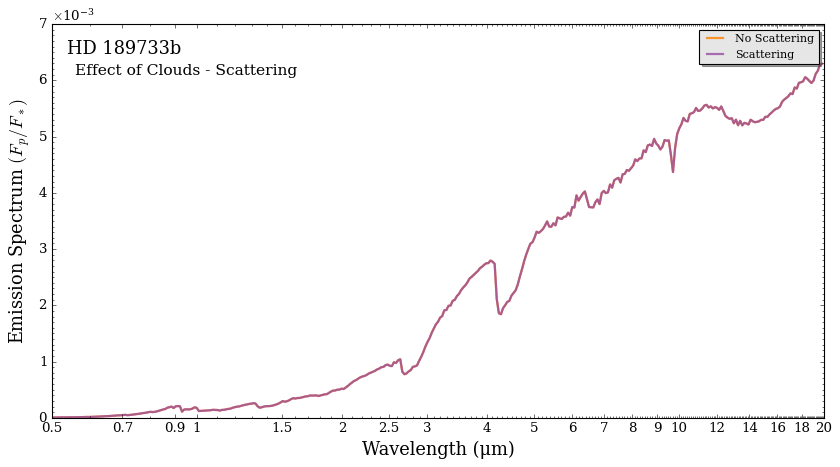

In [18]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere, opac, wl, 
                                 spectrum_type = 'emission')      # <---- Remember to set spectrum_type = 'emission'!

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere, opac, wl, 
                              spectrum_type = 'emission')

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth',                          # <---- Remember to set y_unit!
                        spectra_labels = ['No Scattering', 'Scattering'], 
                        legend_location = 'upper right', wl_axis = 'log',
                        colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title, figure_shape = 'wide')

As we except, both the gas phase and aerosols impart absorption features. Notably, $\rm{CO_2}$ has a large absorption feature between 4-5 um and the forsterite particles impart a spiky feature at 10 um. Since the aerosols are sub-micron, scattering has less of an effect!

### Impact of a thermal inversion

Now let's see what happens when we include a thermal inversion (temperature increases with height). In this case, we except the absorption features from before to flip and become emission features.

We will keep the same aerosol species, but switch to the gradient PT profile, which allows us to define a steep thermal inversion.

In [19]:
#***** Define model *****#

model_name_scattering = 'Thermal Multiple Scattering - Non Isothermal'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['Mg2SiO4_crystalline'] # <---- Lets include crystalline forsterite (Mg2SiO4) crystals, which have sharp features

# Create the model object
model_scattering = define_model(model_name_scattering, bulk_species, param_species, 
                                PT_profile = 'gradient',                 # <---- Lets use a gradient PT profile
                                cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with directional scattering
                                aerosol_species = aerosol_species,
                                scattering = True)                       # <---- Set scattering = True for thermal multiple scattering

model_name_no_scattering = 'No Thermal Multiple Scattering - Non Isothermal'

model_no_scattering = define_model(model_name_no_scattering, bulk_species, param_species, 
                                   PT_profile = 'gradient',                 # <---- Lets use a gradient PT profile
                                   cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with directional scattering
                                   aerosol_species = aerosol_species,
                                   scattering = True)                       # <---- Set scattering = True for thermal multiple scattering


Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


In [20]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

T_high = 1500
T_low = 1200

log_CO                =   -5 # <---- Some proxy gas-phase mixing ratios
log_CO2               =   -5 # <---- Note that gas-phase species have no features in isothermal atmospheres in emission
log_H2O               =   -5

log_P_top_slab_MgSiO3 =   -1    # <---- Top of the slab is at 0.1 bars
Delta_log_P_MgSiO3    =   3     # <---- Slab extends down to 100 bars
log_r_m_MgSiO3        =   0     # <---- Large particles (1 um) have stronger scattering properties 
log_X_MgSiO3          =   -10   # <---- Modest mixing ratio of enstatite in the slab

PT_params = np.array([T_high, T_low])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, cloud_params) 

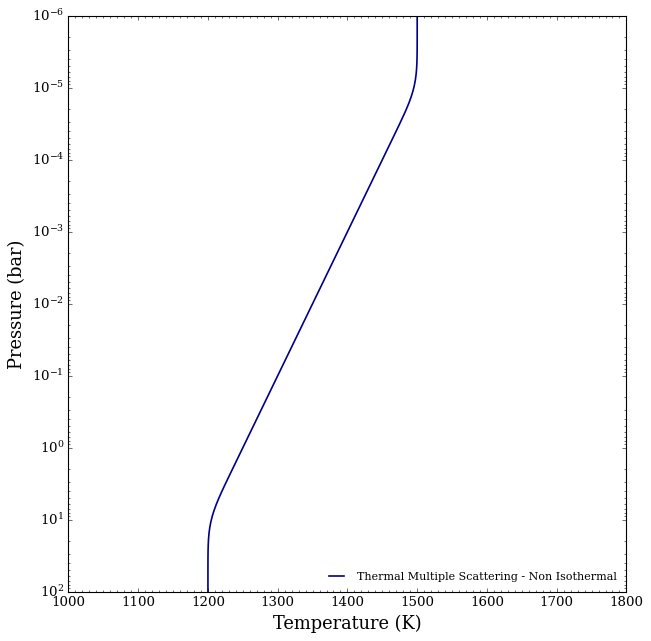

In [21]:
from POSEIDON.visuals import plot_PT

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_scattering, atmosphere,
                 legend_location = 'lower right')

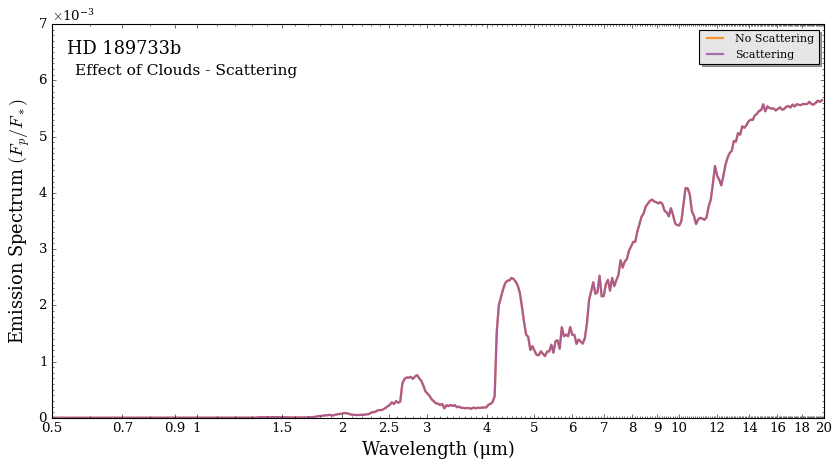

In [22]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere, opac, wl, 
                                 spectrum_type = 'emission')

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere, opac, wl, 
                              spectrum_type = 'emission')

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', 
                        spectra_labels = ['No Scattering', 'Scattering'],
                        legend_location = 'upper right', wl_axis = 'log', 
                        colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title, figure_shape = 'wide')

As we expect, all absorption features have become emission features! 

# 